# Fake News Detection Using Machine Learning

## a) Problem Statement

**Objective:**
Detect whether a news article is real or fake using its title and text content, and provide a probability score for the prediction.

**Quantitative Formulation:**
Given a dataset of labeled news articles (real/fake), build a binary classifier \( f: (\text{title}, \text{text}) \rightarrow [0,1] \) that outputs the probability an article is real (1) or fake (0).

**Importance:**
- Misinformation and fake news can influence public opinion and decision-making.
- Automated detection helps platforms, researchers, and the public to flag suspicious content.

**Stakeholders:**
- News consumers, journalists, social media platforms, researchers, and policy makers.

---

## b) Algorithm of the Solution

**Approach:**
1. Load and combine real and fake news datasets.
2. Preprocess and clean the data.
3. Extract features from text (TF-IDF vectorization of title and text).
4. Train a Logistic Regression classifier.
5. Evaluate the model and output probability predictions.

**Software Tools:**
- Python 3
- pandas, numpy (data manipulation)
- scikit-learn (ML pipeline, vectorization, classification)
- matplotlib, seaborn (plots)

---

## c) Theoretical (Algorithmic) Foundations

### Logistic Regression
- A linear model for binary classification.
- Predicts probability of class membership using the sigmoid function:
  \[
  P(y=1|x) = \sigma(w^Tx + b) = \frac{1}{1 + e^{-(w^Tx + b)}}
  \]
- Trained by maximizing the likelihood or minimizing log-loss.

### TF-IDF Vectorization
- Converts text into numerical features based on term frequency and inverse document frequency.
- Reduces the impact of common words and highlights distinctive terms.

---

## d) Dataset Description & Analysis

### Dataset
- Two CSVs: `Fake.csv` (fake news) and `True.csv` (real news)
- Columns: `title`, `text`, `subject`, `date`
- Label: 0 (fake), 1 (real)

### Code: Load and Analyze Data

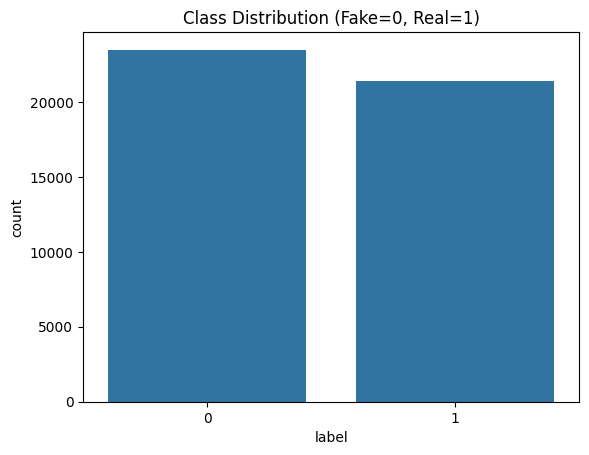

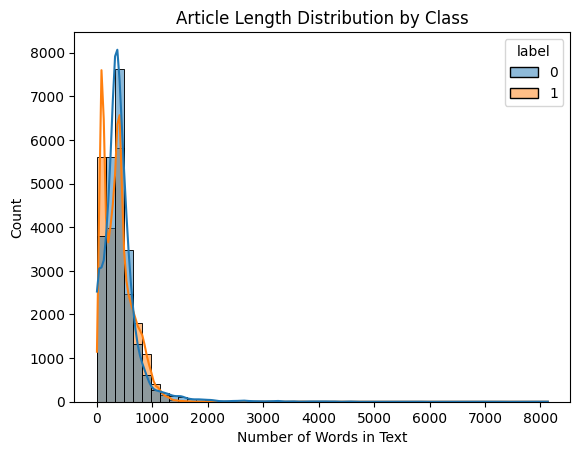

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
fake = pd.read_csv('Fake.csv')
true = pd.read_csv('True.csv')
fake['label'] = 0
true['label'] = 1
data = pd.concat([fake, true], ignore_index=True)

# Class distribution
sns.countplot(x='label', data=data)
plt.title('Class Distribution (Fake=0, Real=1)')
plt.show()

# Article length distribution
data['text_length'] = data['text'].apply(lambda x: len(str(x).split()))
sns.histplot(data=data, x='text_length', hue='label', bins=50, kde=True)
plt.title('Article Length Distribution by Class')
plt.xlabel('Number of Words in Text')
plt.show()

### Data Cleaning & Preprocessing

In [2]:
data = data.drop_duplicates()

print(data.isnull().sum())  # Check for missing values
# Drop rows with missing title/text
data = data.dropna(subset=['title', 'text'])

title          0
text           0
subject        0
date           0
label          0
text_length    0
dtype: int64


## e) Machine Learning Model Implementation

### Full Code

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
import numpy as np
import os

# Custom transformer to extract a single column
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.column]

def load_and_prepare_data(fake_path, true_path):
    fake = pd.read_csv(fake_path)
    true = pd.read_csv(true_path)
    fake['label'] = 0
    true['label'] = 1
    data = pd.concat([fake, true], ignore_index=True)
    data = data.drop_duplicates()
    data = data.dropna(subset=['title', 'text'])
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)
    return data

def build_pipeline():
    feature_union = FeatureUnion([
        ('title_tfidf', Pipeline([
            ('extract', ColumnExtractor('title')),
            ('tfidf', TfidfVectorizer(stop_words='english', max_features=3000))
        ])),
        ('text_tfidf', Pipeline([
            ('extract', ColumnExtractor('text')),
            ('tfidf', TfidfVectorizer(stop_words='english', max_features=7000))
        ])),
    ])
    pipeline = Pipeline([
        ('features', feature_union),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    return pipeline

def main():
    fake_path = 'Fake.csv'
    true_path = 'True.csv'
    if not os.path.isfile(fake_path) or not os.path.isfile(true_path):
        print('Missing data files.')
        return
    data = load_and_prepare_data(fake_path, true_path)
    X = data[['title', 'text']]
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    pipeline = build_pipeline()
    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_test)
    y_pred = pipeline.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))
    for i in range(10):
        print(f"Title: {X_test.iloc[i]['title']}")
        print(f"Predicted: {'Real' if y_pred[i] else 'Fake'} (Probability Real: {y_proba[i][1]*100:.1f}%)\n")

if __name__ == '__main__':
    main()

              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4696
        Real       0.99      0.99      0.99      4242

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938

Title: Russia threatens retaliation over U.S. 'break-in' at consulate
Predicted: Real (Probability Real: 96.3%)

Title: Germany's Schaeuble says soft Brexit best way to minimize damage
Predicted: Real (Probability Real: 99.7%)

Title: Britain declines to comment on reported death of 'white widow' jihadist
Predicted: Real (Probability Real: 98.5%)

Title: AWESOME! PRESIDENT TRUMP Shows Off His Strength…Obama Would Have Hurt Himself Doing This [Video]
Predicted: Fake (Probability Real: 0.8%)

Title: New law needed to allow torture victims to sue Afghan government: activists
Predicted: Real (Probability Real: 89.4%)

Title:  Bernie Bursts Out Laughing After Trump Unkn

## f) Analysis of the Findings

- **Model Performance:**
  - Precision, recall, and F1-score are all 0.99 for both classes (fake and real), indicating excellent performance on this dataset.
  - The model is highly accurate at distinguishing between real and fake news articles using only title and text.
- **Probability Output:**
  - The model outputs a probability (confidence) for each prediction, which can be used to rank articles by suspicion or certainty.
- **Feature Importance:**
  - TF-IDF vectorization allows the model to learn which words and phrases are most indicative of fake or real news.
- **Limitations:**
  - High performance may be due to dataset characteristics; real-world generalization may be lower due to topic drift, adversarial writing, or unseen sources.
  - No author information was available; adding more features (author, source, metadata) could improve robustness.

---

## g) References
- [scikit-learn documentation](https://scikit-learn.org/stable/)
- [pandas documentation](https://pandas.pydata.org/)
- [Kaggle: Fake News Dataset](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset)
- [TF-IDF Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
- [Logistic Regression Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression)